# Applied Science Take-Home Exercise
This notebook can act as a boilerplate to help you along the road, do not feel obliged to submit everything via a notebook or make your customizations/ do things differently to how it is presented here.

In `semantic_parsing_dialog` there are three functions that should help you:
- `load_dataset()` which loads a local tsv file as a huggingface Dataset
- `postprocess_test()` which helps clean up predictions so that
- `evaluate_predictions()` can be used to produce various model evaluation metrics

### What we are looking for:
- Can you create a basic baseline model? Why have you chosen this implementation?
- What are the steps have you taken (please make sure your thinking is well commented)
- Try to experiment with methods to improve your basic baseline architecture
- How are you evaluating & comparing your training runs?
- Given more time what would you do?
    - architecture strategies
    - relevant research papers

### Submission
- Check-in your solution to a new branch and create a PR (`!git checkout -b 'submission'`)
- Please make sure to include your predictions using two files called **data/submission_mce.tsv** and **data/submission_ccf.tsv**. The former should contain the prediction of the model trained with cross-entropy loss and the latter file containing the results of training with a custom cost function written by you. Make sure to compare the result of these two experiments.

# Set Up

The first cells are just preparing the environment and mounting the required volumes in Google Colab.

In [1]:
%env PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128
!export | grep PYTORCH_CUDA_ALLOC_CONF

env: PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128
declare -x PYTORCH_CUDA_ALLOC_CONF="garbage_collection_threshold:0.6,max_split_size_mb:128"


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import sys
import torch

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
sys.path.append('/content/gdrive/MyDrive/UnlikelyAI/Slots-and-intents-FengTian/semantic_parsing_dialog')

In [ ]:
# nb_path = '/content/notebooks'
# os.symlink('/content/gdrive/MyDrive/UnlikelyAI/Slots-and-intents-FengTian/', nb_path)
# sys.path.insert(0,nb_path)

In [4]:
%cd /content/gdrive/MyDrive/UnlikelyAI/Slots-and-intents-FengTian/

# ! ls
# !pip install -r requirements.txt
# !pip install accelerate
# !pip install optimum
# !pip install pynvml

/content/gdrive/MyDrive/UnlikelyAI/Slots-and-intents-FengTian


In [ ]:
# use an experiment tracking tool of your own choice, here we use Wandb
import wandb

wandb.login()

wandb: Currently logged in as: offtian. Use `wandb login --relogin` to force relogin


True

# Load the Dataset

In [ ]:
# Check you are connected to a GPU-enabled instance.

print(torch.cuda.is_available()) # should be TRUE if GPU is expected

True


In [148]:
from semantic_parsing_dialog import ROOT
from semantic_parsing_dialog import device

from semantic_parsing_dialog.utils import load_datasets, load_semantic_vocab
from semantic_parsing_dialog.vocab import get_intents, get_slots


datapath = os.path.join(ROOT, 'data')

dataset = load_datasets(datapath)
semantic_vocab = load_semantic_vocab(datapath)

# Task Data Analysis

Before jumping into the exercise, we'll have a look at some simple statistics of the task-oriented semantical vocabulary

#### Slots and intents

A quick analysis to have a feeling of the variability in terms of complexity for the different intents.

Here we look at co-occurrences of intents and certain slots within the same query - without caring about whether slots are part of its semantics or part of other intents that form the composed query.  

In [180]:
df = dataset['train'].to_pandas()

df['intent'] = df['representation'].map(get_intents)
df['slot'] = df['representation'].map(get_slots)

df['n_intent'] = df['intent'].map(len)
df['n_slot'] = df['slot'].map(len)

In [183]:
df['intent'].explode().value_counts()

GET_DISTANCE               1709
GET_LOCATION               1121
GET_ESTIMATED_ARRIVAL      1066
UNSUPPORTED                1046
GET_LOCATION_HOME           660
GET_ESTIMATED_DEPARTURE     346
UNSUPPORTED_EVENT           298
UPDATE_DIRECTIONS           225
GET_INFO_ROUTE               44
GET_LOCATION_SCHOOL          34
UNINTELLIGIBLE                4
GET_EVENT_ATTENDEE            2
GET_EVENT_ORGANIZER           2
Name: intent, dtype: int64

In [181]:
from typing import Dict, List, Union
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_occurrence(df: pd.DataFrame) -> Dict[Union[str, tuple], int]:
    """
    Calculate the occurrence of intent-slot pairs in a DataFrame.

    Args:
    df (pd.DataFrame): A DataFrame containing 'intent' and 'slot' columns.

    Returns:
    Dict[Union[str, tuple], int]: A dictionary where keys are intent-slot pairs (tuple)
    or individual intents (string) and values are the occurrence counts.
    """
    intent_slot_occurrence = {}

    for index, row in df.iterrows():
        intents = row['intent']
        slots = row['slot']

        for intent in intents:
            for slot in slots:
                pair = (intent, slot)
                intent_slot_occurrence[pair] = intent_slot_occurrence.get(pair, 0) + 1

    return intent_slot_occurrence

occurrence = calculate_occurrence(df)
occurrence_df = pd.DataFrame.from_dict(occurrence, orient='index').reset_index()
occurrence_df[['Intent', 'Slot']] = occurrence_df['index'].apply(lambda x: pd.Series(list(x)))
occurrence_df = occurrence_df.drop(columns=['index'])

occurrence_df.columns = ['Count', 'Intent', 'Slot']

heatmap_data = occurrence_df.pivot('Intent', 'Slot', 'Count').fillna(0)
heatmap_data = heatmap_data.astype(int)  # Convert to integer

<ipython-input-181-4f5af5d95964>:26: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = occurrence_df.pivot('Intent', 'Slot', 'Count').fillna(0)


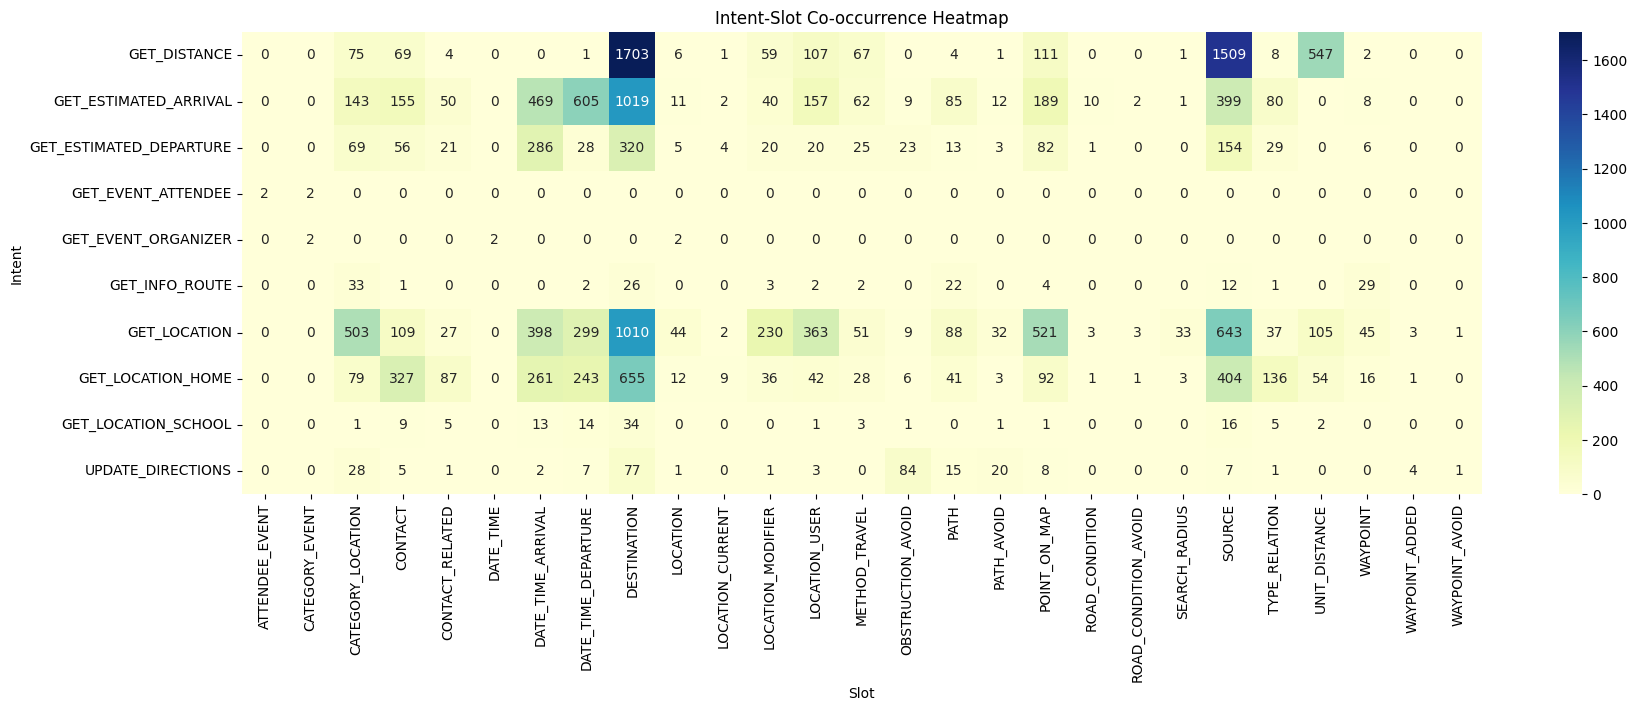

In [ ]:
plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_data, annot=True,fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Intent-Slot Co-occurrence Heatmap')
plt.show()

In [ ]:
# TODO: Inspect any other aspect of the dataset relevant to the task at hand

In [ ]:
## Inspect the token length to determine max length for modelling
df.utterance.apply(lambda x: len(x.split())).describe()

count    4796.000000
mean        9.707465
std         3.945737
min         1.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        51.000000
Name: utterance, dtype: float64

In [ ]:
df.representation.apply(lambda x: len(x.split())).describe()

count    4796.000000
mean       17.053169
std         7.761264
min         3.000000
25%        12.000000
50%        15.000000
75%        21.000000
max        58.000000
Name: representation, dtype: float64

# Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
# TODO
# model_name_or_path = "facebook/bart-base" # TODO: write name
model_name_or_path = "T5-small"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

# TODO:
max_source_length = 128
max_target_length = 128

model.config.max_length = max_target_length

In [ ]:
from typing import List

def extend_vocabulary(tokenizer: AutoTokenizer, model: AutoModelForSeq2SeqLM, tokens: List[str]) -> None:
    """ Extends the model's original vocabulary to accommodate new tokens

    The are added at the end of the tokenizer's vocabulary
    """
    # TODO
    # check if the new tokens are already in the vocabulary
    print(len(tokenizer))  # 32100
    tokens = set(tokens) - set(tokenizer.vocab.keys())

    # add the tokens to the tokenizer vocabulary
    tokenizer.add_tokens(list(tokens))

    # add new, random embeddings for the new tokens
    print(len(tokenizer))  # 32141
    model.resize_token_embeddings(len(tokenizer))


In [ ]:
intents = list(semantic_vocab['intents'].values())
slots = list(semantic_vocab['slots'].values())

In [ ]:
extend_vocabulary(tokenizer, model, intents+slots)
extend_vocabulary(tokenizer, model, ["[", "]"])
# tokenizer.save_pretrained('custom_T5_tokenizer')

32100
32141
32141
32141


# Training

#### Model training with cross-entropy loss

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, Trainer

from semantic_parsing_dialog import evaluate_predictions, postprocess_text

In [ ]:
def combine_utterance_intents_slots(data: dict) -> dict:
    """
    Label semantic aware intent-slot filling
    Combine intents and slots with utterances in a given dataset.
    Following this research paper
    "Label Semantic Aware Pre-training for Few-shot Text Classification":
    https://arxiv.org/pdf/2204.07128v2.pdf

    This function takes a dictionary containing utterances, intents, and slots
    and combines them into a new dictionary, where each utterance is enriched
    with its associated intents and slots in a specified format.

    Args:
    data (dict): A dictionary with the following keys:
        - 'utterance' (list): A list of utterances.
        - 'intents' (list of lists): A list of intent lists corresponding to each utterance.
        - 'slots' (list of lists): A list of slot lists corresponding to each utterance.

    Returns:
    dict: A new dictionary with the following keys:
        - 'utterance_new' (list): A list of combined utterances with intents and slots.
        - 'utterance' (list): The original list of utterances from the input data.
        - 'representation' (list): The original list of representations from the input data.

    Example:
    >>> data = {
    ...     "utterance": ["u1", "u2"],
    ...     "intents": [["intents_1", "intents_2"], ["intents_2"]],
    ...     "slots": [["slots_1", "slots_2"], ["slots_2"]]
    ... }
    >>> result = combine_utterance_intents_slots(data)
    >>> print(result["utterance_new"])
    ["IN:intents_1, IN:intents_2: utterance_1, SL:slots_1, SL:slots_2", "IN:intents_2: utterance_2, SL:slots_2"]
    """

    combined_data = {
        "utterance_new": [],
        "utterance": data['utterance'],
        "representation": data['representation']
    }

    for i in range(len(data["utterance"])):
        intents = data["intents"][i]
        intent_str = ", ".join(["IN:" + intent for intent in intents])
        slots = data["slots"][i]
        slot_str = ", ".join(["SL:" + slot for slot in slots]) if slots else ""

        if slot_str:
            combined_str = f"{intent_str}: {data['utterance'][i]} {slot_str}"
        else:
            combined_str = f"{intent_str}: {data['utterance'][i]}"

        combined_data["utterance_new"].append(combined_str)

    return combined_data

In [ ]:
def preprocess_function(sample) -> dict:
    """
    Preprocesses a batch data for input to a Seq2Seq model.

    Args:
    sample (dict): A dictionary containing 'representation' and 'utterance' fields.

    Returns:
    dict: A dictionary of preprocessed model inputs and labels.

    This function performs the following steps:
    1. Extracts intents and slots from the 'representation'.
    2. Combines intents and slots with utterances.
    3. Tokenizes the input utterance and converts it to tensors.
    4. Tokenizes the target representation and converts it to tensors.
    5. Replaces padding tokens in labels with -100 to ignore them during loss computation.

    The returned dictionary includes 'input_ids', 'attention_mask', and 'labels' for model input.
    """

    # TODO
    sample['intents'] = [get_intents(i) for i in sample['representation']]
    sample['slots'] = [get_slots(i) for i in sample['representation']]

    sample_new = combine_utterance_intents_slots(sample)

    # Tokenise the input utterance and convert to tensors
    model_inputs = tokenizer(
        sample_new["utterance_new"],
        truncation=True,
        padding="max_length",
        max_length=max_source_length,
        return_tensors="pt",
    )

    # Tokenize the target representation and convert to tensors
    with tokenizer.as_target_tokenizer():
      labels = tokenizer(
          sample_new["representation"],
          truncation=True,
          padding="max_length",
          max_length=max_target_length,
          return_tensors="pt",
      )

    # Replace all tokenizer.pad_token_id in the labels by -100
    # when we want to ignore padding in the loss.
    labels["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in l]
        for l in labels["input_ids"]
    ]
    # Create the model inputs dictionary
    model_inputs['labels'] = labels["input_ids"]

    return model_inputs

In [ ]:
# TODO
tokenized_dataset = dataset.map(
    lambda batch_sample: preprocess_function(batch_sample),
    batched=True,
)
train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['eval']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/4796 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/694 [00:00<?, ? examples/s]

Map:   0%|          | 0/1327 [00:00<?, ? examples/s]

In [ ]:
# TODO
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# PUT YOUR CODE HERE
# you may want to alter the hyperparams
training_args = Seq2SeqTrainingArguments(
    output_dir="checkpoints",
    overwrite_output_dir=True,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    predict_with_generate=True,
    fp16=False,
    learning_rate=5e-1,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="no", # changed to `no` due to limited gdrive space
    report_to="wandb",
    # load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # compute_metrics=compute_metrics,
    # callbacks=..
)

In [ ]:
# log experiments
# depending on how you implement the model, logging may be done differently.
with wandb.init(project="semantic_parsing_dialog") as run:
    trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.731620
2,No log,0.830138
3,No log,0.778372
4,No log,0.748770
5,No log,0.717700
6,No log,0.710062
7,0.869400,0.717847
8,0.869400,0.703005
9,0.869400,0.693470
10,0.869400,0.692521


eval/loss,▃█▅▄▂▂▂▂▁▁
eval/runtime,▂▅▄▄█▁▃▆▂▂
eval/samples_per_second,▇▄▅▅▁█▆▃▇▇
eval/steps_per_second,▇▄▅▅▁█▆▃▇▇
train/epoch,▁▂▃▃▄▅▅▆▆▇██
train/global_step,▁▂▃▃▄▅▅▆▆▇██
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
trainer.save_model(output_dir="best_model")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
def report_gpu():
   print(torch.cuda.list_gpu_processes())
   gc.collect()
   torch.cuda.empty_cache()

report_gpu()

GPU:0
process     498982 uses     2534.000 MB GPU memory


#### Model training with a custom loss function

There are several intents with long tails in the training dataset, i.e. co-occurrence with a large cardinality of slots with low volume/representation in the training set. These cases could present learning challenges for the model. Incorporate a custom loss function in the training pipeline that takes into account the data imbalance.

In [ ]:
from torch import nn
from transformers import Seq2SeqTrainer

def compute_class_weights(labels):
    # Compute class weights based on the representation of each class in the labels
    # Convert labels to a tensor if it's not already
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)
    unique_labels, counts = torch.unique(labels, return_counts=True)
    class_weights = torch.ones(len(unique_labels), dtype=torch.float32)  # Initialize with ones for all classes
    total_sample = labels.numel()

    # Calculate class weights based on the number of samples per class
    for i, label in enumerate(unique_labels):
        class_weights[label] =  total_sample / (counts[i] + 1e-5)

    return class_weights

class CustomTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.

        Subclass and override for custom behavior.
        """
        #  TODO: Incorporate a custom loss function in the training pipeline.
        labels = inputs.pop("labels")
        # Forward pass through the model to get the output logits
        outputs = model(**inputs)

        # Extract the logits and labels from the model outputs
        logits = outputs.logits

        # Calculate class weights based on data imbalance
        class_weights = compute_class_weights(labels).to(device)

        # Calculate the weighted cross-entropy loss
        loss_fn = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights)
        loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [ ]:
trainer_new = CustomTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # compute_metrics=..,
    # callbacks=..
)

In [ ]:
# log experiments
with wandb.init(project="semantic_parsing_dialog_custom_cost") as run:
    trainer_new.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


IndexError: ignored

## Computing metrics

We strongly recommend you use the given `evaluate_predictions` and `postprocess_text` functions

In [ ]:
import wandb
import numpy as np
from semantic_parsing_dialog import evaluate_predictions, postprocess_text


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = postprocess_text(decoded_preds)
    decoded_labels = postprocess_text(decoded_labels)
    return evaluate_predictions(decoded_labels, decoded_preds)

# Evaluate and compare the models

In [ ]:
model_ckpt = '/content/gdrive/MyDrive/UnlikelyAI/Slots-and-intents-FengTian/best_model'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

model = model.cuda()

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # compute_metrics=compute_metrics,
    # callbacks=..
)

In [ ]:
tokenized_dataset = dataset.map(
    lambda batch_sample: preprocess_function(batch_sample),
    batched=True,
)
train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['eval']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/4796 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/694 [00:00<?, ? examples/s]

Map:   0%|          | 0/1327 [00:00<?, ? examples/s]

In [156]:
from torch.utils.data import DataLoader
import torch

def evaluate(dataset: dict, model: AutoModelForSeq2SeqLM, tokenizer: AutoTokenizer, batch_size: int=16) -> Dict[str, Union[float, int]]:
    """
    Evaluates the model on the given dataset.

    Args:
    dataset (dict): The evaluation dataset.
    model (AutoModelForSeq2SeqLM): The trained model to evaluate.
    tokenizer (AutoTokenizer): The tokenizer used for tokenizing text data.
    batch_size (int, optional): Batch size for evaluation. Defaults to 16.

    Returns:
    Dict[str, Union[float, int]]: A dictionary of evaluation metrics.

    This function performs the following steps:
    1. Creates a DataLoader for the evaluation dataset.
    2. Initializes lists to store predictions and labels.
    3. Sets the model to evaluation mode.
    4. Iterates through the batches and makes predictions.
    5. Computes evaluation metrics using the provided compute_metrics function.
    """
    # Create a DataLoader for the evaluation dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_tokenize)

    # Initialize lists to store predictions and labels
    all_predictions = []
    all_labels = []

    # Set the model to evaluation mode
    model.eval()

    # Iterate through the batches and make predictions
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Generate predictions
        with torch.no_grad():
            model_outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                decoder_input_ids=labels ## comment if using model.generate
                # max_length=128,  ## uncomment if using model.generate
                # num_return_sequences=1, ## uncomment if using model.generate
            )

        # Postprocess and store predictions
        all_predictions.extend(model_outputs.logits.argmax(-1))

        # Store the labels
        if 'labels' in batch:
            labels = batch['labels']
            all_labels.extend(labels)

    # Compute evaluation metrics using the provided compute_metrics function
    eval_metrics = compute_metrics((all_predictions, all_labels))

    return eval_metrics

def collate_tokenize(batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
    """
    Tokenizes and collates a batch of data.

    Args:
    batch (List[Dict[str, Any]]): A batch of data samples, where each sample is a dictionary.

    Returns:
    Dict[str, torch.Tensor]: A dictionary containing tokenized input and labels.
    """
    text_batch = [element["utterance"] for element in batch]
    labels_batch = [element["representation"] for element in batch]

    tokenized = tokenizer(text_batch, padding='max_length', truncation=True, return_tensors='pt')
    labels = tokenizer(labels_batch, padding='max_length', truncation=True, return_tensors='pt')
    labels["labels"] = [
          [-100 if token == tokenizer.pad_token_id else token for token in l]
          for l in labels["input_ids"]
      ]
    tokenized['labels'] = labels["input_ids"]
    return tokenized

In [ ]:
evaluate(test_dataset, model, tokenizer, batch_size=16)

2023-09-18 15:42:06.289 | WARNING  | semantic_parsing_dialog.evaluate:evaluate_predictions:100 - Found invalid line in pred file: IN:GET_ESTIMATED_ARRIVAL What is the ] ] ] ]
2023-09-18 15:42:06.290 | WARNING  | semantic_parsing_dialog.evaluate:evaluate_predictions:100 - Found invalid line in pred file: IN:UNSUPPORTED What is [ [ ]
2023-09-18 15:42:06.291 | WARNING  | semantic_parsing_dialog.evaluate:evaluate_predictions:100 - Found invalid line in pred file: IN:GET_ESTIMATED_ARRIVAL What What [ ]
2023-09-18 15:42:06.292 | WARNING  | semantic_parsing_dialog.evaluate:evaluate_predictions:100 - Found invalid line in pred file: IN:GET_ESTIMATED_ARRIVAL What is What is is the [ ] ]
2023-09-18 15:42:06.293 | WARNING  | semantic_parsing_dialog.evaluate:evaluate_predictions:100 - Found invalid line in pred file: IN:GET_ESTIMATED_ARRIVAL What is the [ [ ] ] ] ]
2023-09-18 15:42:06.295 | WARNING  | semantic_parsing_dialog.evaluate:evaluate_predictions:100 - Found invalid line in pred file: IN:U

{'instance_count': 1327,
 'exact_match': 0.0,
 'labeled_bracketing_scores': {'precision': 0, 'recall': 0.0, 'f1': 0},
 'tree_labeled_bracketing_scores': {'precision': 0, 'recall': 0.0, 'f1': 0},
 'tree_validity': 0.05953278070836476}

# Save predictions over test dataset

In [ ]:
# !pip install --force-reinstall torch==1.12.1+cu113 --extra-index-url https://download.pytorch.org/whl/

In [158]:
report_gpu()

GPU:0
process     498982 uses    40260.000 MB GPU memory


In [118]:
trainer.evaluate(tokenized_dataset["test"])

{'eval_loss': 0.6758615374565125,
 'eval_runtime': 3.0299,
 'eval_samples_per_second': 437.963,
 'eval_steps_per_second': 13.862}

In [155]:
test_dataset

Dataset({
    features: ['utterance', 'representation', 'intents', 'slots', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1327
})

In [153]:
# make predictions over test set
output = trainer.predict(test_dataset, ignore_keys=['utterance', 'representation'])

RuntimeError: ignored

In [159]:
# Create a DataLoader for the evaluation dataset
dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_tokenize)

# Initialize lists to store predictions and labels
all_predictions = []

# Set the model to evaluation mode
model.eval()

# Iterate through the batches and make predictions
for batch in dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Generate predictions
    with torch.no_grad():
        model_outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=labels ## comment if using model.generate
            # max_length=128,  ## uncomment if using model.generate
            # num_return_sequences=1, ## uncomment if using model.generate
        )

    # Postprocess and store predictions
    all_predictions.extend(model_outputs.logits.argmax(-1))

In [160]:
# save predictions
predictions = tokenizer.batch_decode(all_predictions, skip_special_tokens=True)

In [163]:
# check the length are the same
assert len(predictions) == len(test_dataset)

In [165]:
with open("data/submission_mce.tsv", "w") as f:
    f.write("\n".join(postprocess_text(predictions)))

# Check in your submission to your branch and make a PR.

**please make sure to include your predictions in a file called *data/submission.tsv***

In [169]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [171]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   exercise_boilerplate.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	best_model/
	data/submission.tsv
	data/submission_mce.tsv
	semantic_parsing_dialog/__pycache__/

no changes added to commit (use "git add" and/or "git commit -a")


In [176]:
! git checkout -b 1-t5-model-train

Switched to a new branch '1-t5-model-train'


In [174]:
! git config --global user.email "oliver.fengtian@gmail.com"
! git config --global user.name "Ollie"

In [177]:
! git add data/submission.tsv exercise_boilerplate.ipynb

In [178]:
! git commit -m "Updated exercise_boilerplate with T5-small model training scripts with final submission"

[1-t5-model-train 696e72b] Updated exercise_boilerplate with T5-small model training scripts with final submission
 1 file changed, 1 insertion(+), 1 deletion(-)


In [179]:
! git push origin 1-t5-model-train

Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 12 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 185.88 KiB | 6.64 MiB/s, done.
Total 8 (delta 5), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), completed with 2 local objects.
remote: 
remote: Create a pull request for '1-t5-model-train' on GitHub by visiting:
remote:      https://github.com/unlikelyai-interview/Slots-and-intents-FengTian/pull/new/1-t5-model-train
remote: 
To https://github.com/unlikelyai-interview/Slots-and-intents-FengTian.git
 * [new branch]      1-t5-model-train -> 1-t5-model-train


# Next steps

In [ ]:
# TODO

## A. Current approach

The current model is a basic Transformer NLU Seq2Seq pipeline where I trained `T5-small` pretrained model to predict representation from given utterance.

I attempted various sequence pretrained model including `BART`, `T5-base` however due to computational restriction on collab, I decided to end up with `T5-small`.

In addition to encoding the intents and slots, inspired by this research paper  [***Label Semantic Aware Pre-training for Few-shot Text Classification (Mueller et al., 2022)***](https://arxiv.org/pdf/2204.07128v2.pdf), I added the intents and slots back into utterance in a format of "IN_1, IN_2: U_1. SL_1, SL_2", which greatly reduced the entropy loss.


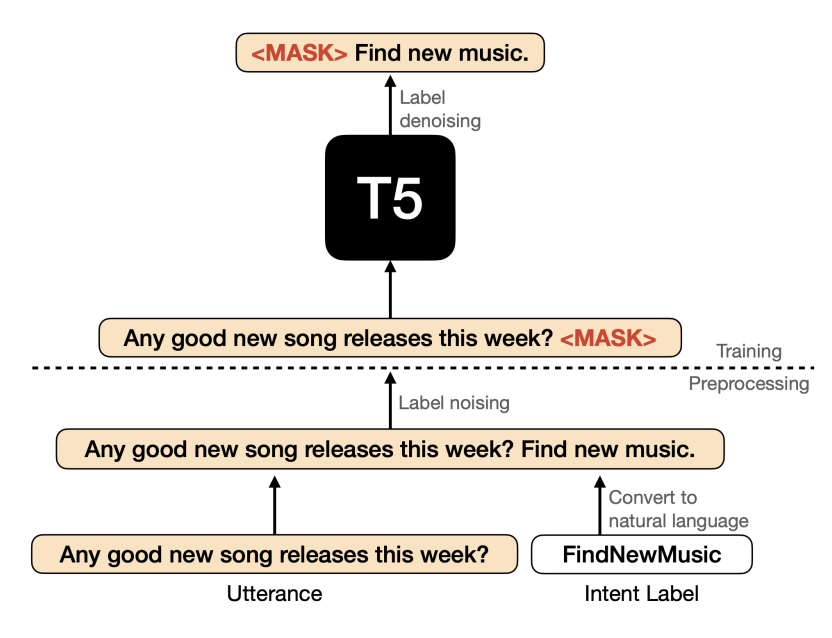

In this task, I attempted to implement class weight to handle the class imbalance but my code didn't work as expected.

Following the evaluation, I realised that my model was not predicting or generating the expected representation.

## B. Next steps

With more time, I would:


* Conduct an extensive hyperparameter search to fine-tune the model
* Investigate Out-of-Vocabulary in the dataset
* Attempt other non-transfomer Seq2Seq approach e.g. LSTM.
* Incorporate hierarchical representations of intents and slots in utterance
* Separate intent classification and slot filling tasks into two models and then compare results.
* Data augmentation with back translation (English -> French -> English) [CST5: Data Augmentation for Code-Switched Semantic Parsing](https://arxiv.org/pdf/2211.07514v1.pdf)

Other useful research:

- Pre-training Intent-Aware Encoders for Zero- and Few-Shot Intent
Classification (Sung et al., 2023)
- Label Semantic Aware Pre-training for Few-shot Text Classification
(Mueller et al., 2023)
- RETRONLU: Retrieval Augmented Task-Oriented Semantic Parsing (Gupta et al., 2019)

In [185]:
! git add exercise_boilerplate.ipynb

In [186]:
! git commit -m "Updated the notebook with next steps and relevant research."

[1-t5-model-train b4d96ce] Updated the notebook with next steps and relevant research.
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite exercise_boilerplate.ipynb (65%)


In [187]:
! git push origin 1-t5-model-train

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 12 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 106.53 KiB | 4.10 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/unlikelyai-interview/Slots-and-intents-FengTian.git
   696e72b..b4d96ce  1-t5-model-train -> 1-t5-model-train


In [6]:
! git status

On branch 1-t5-model-train
Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    data/submission.tsv
	modified:   exercise_boilerplate.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	best_model/
	data/submission_mce.tsv
	semantic_parsing_dialog/__pycache__/

no changes added to commit (use "git add" and/or "git commit -a")


In [7]:
! git add data/submission_mce.tsv data/submission.tsv exercise_boilerplate.ipynb


In [ ]:
! git commit -m "Updated function docstrings and renamed submission_mce"